# CS736 Q4: Dictionary Learning and Denoising for Chest CT

This notebook implements dictionary learning with column norm constraints and uses the learned dictionary to denoise a chest CT image, following parts (a)-(c) of the assignment.

MAT keys: ['imageChestCT']
Image shape: (512, 512) min= 0.0 max= 1.0


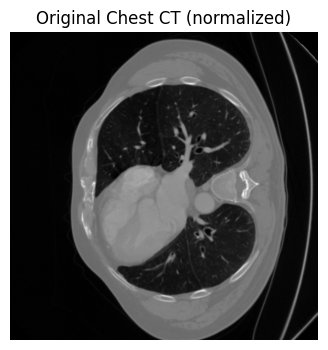

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

mat_path = "data/assignmentImageDenoising_chestCT.mat"
with h5py.File(mat_path, 'r') as f:
    keys = list(f.keys())
    print("MAT keys:", keys)
    chest_ct = np.array(f[keys[0]]).astype(np.float32)
    if chest_ct.ndim > 2:
        chest_ct = chest_ct.squeeze()

min_v, max_v = chest_ct.min(), chest_ct.max()
chest_ct = (chest_ct - min_v) / (max_v - min_v + 1e-12)  # normalize to [0,1] for stable sparse coding
print("Image shape:", chest_ct.shape, "min=", chest_ct.min(), "max=", chest_ct.max())

plt.figure(figsize=(4,4))
plt.imshow(chest_ct, cmap='gray')
plt.title('Original Chest CT (normalized)')
plt.axis('off')
plt.show()

Total patches: 16129 Selected subset: 5968


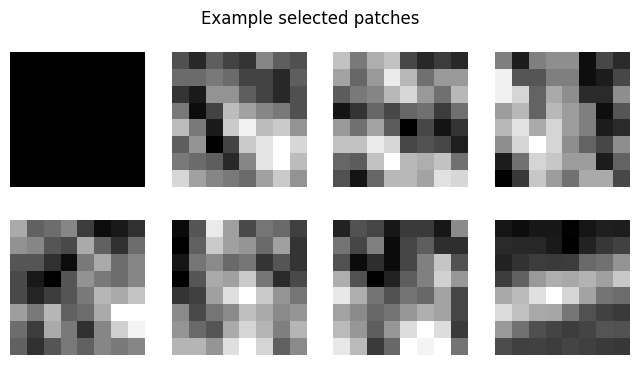

In [ ]:
# Extracting 8×8 Patches for aelect High-Variance subset
from skimage.util import view_as_windows

patch_size = 8
stride = 4

def extract_patches(image, patch_size=8, stride=1):
    patches = view_as_windows(image, (patch_size, patch_size), step=stride)
    h, w, _, _ = patches.shape
    patches = patches.reshape(-1, patch_size, patch_size)
    n = patches.shape[0]
    patches_flat = patches.reshape(n, patch_size*patch_size).T  # (pdim, n)
    positions = [(i, j) for i in range(h) for j in range(w)]
    return patches_flat, positions, h, w

rng = np.random.default_rng(0)

def select_patches_mixed_variance(patches_flat, high_percentile=70, low_fraction=0.10, cap_total=50000):
    variances = patches_flat.var(axis=0)
    hi_thresh = np.percentile(variances, high_percentile)
    hi_idx = np.where(variances >= hi_thresh)[0]
    lo_idx = np.where(variances < hi_thresh)[0]
    lo_sample = rng.choice(lo_idx, size=int(low_fraction * len(lo_idx)), replace=False) if len(lo_idx) > 0 else np.array([], dtype=int)
    mixed_idx = np.unique(np.concatenate([hi_idx, lo_sample]))
    if len(mixed_idx) > cap_total:
        mixed_idx = rng.choice(mixed_idx, size=cap_total, replace=False)
    return mixed_idx, variances

patches_flat, positions, hpos, wpos = extract_patches(chest_ct, patch_size=patch_size, stride=stride)
sel_idx, variances = select_patches_mixed_variance(patches_flat, high_percentile=70, low_fraction=0.10, cap_total=50000)
X = patches_flat[:, sel_idx]
print("Total patches:", patches_flat.shape[1], "Selected subset:", X.shape[1])

plt.figure(figsize=(8,4))
for k in range(8):
    plt.subplot(2,4,k+1); plt.imshow(X[:,k].reshape(patch_size,patch_size), cmap='gray'); plt.axis('off')
plt.suptitle("Example selected patches")
plt.show()

In [ ]:
import scipy.fftpack as fftpack

def dct2_basis(patch_size=8):
    ps = patch_size
    basis = []
    for u in range(ps):
        for v in range(ps):
            x = np.arange(ps)
            Cu = np.cos((np.pi*(2*x+1)*u)/(2*ps))
            Cv = np.cos((np.pi*(2*x+1)*v)/(2*ps))
            Bu = Cu / np.linalg.norm(Cu)
            Bv = Cv / np.linalg.norm(Cv)
            img = np.outer(Bu, Bv)
            basis.append(img)
    basis = np.stack(basis, axis=0) 
    return basis

pdim = patch_size * patch_size
K = 64
basis_imgs = dct2_basis(patch_size)
D0 = basis_imgs.reshape(K, pdim).T  

# Normalize columns to satisfy ||d_k||_2 <= 1
col_norms = np.linalg.norm(D0, axis=0)
col_norms[col_norms == 0] = 1.0
D0 = D0 / col_norms
print("D0 shape:", D0.shape, "max column norm:", np.max(np.linalg.norm(D0, axis=0)))

D0 shape: (64, 64) max column norm: 1.0000000000000002


In [ ]:
# Column normalization (projection onto unit l2 ball)
def normalize_dictionary(D):
    norms = np.linalg.norm(D, axis=0)
    norms[norms == 0] = 1.0
    return D / np.maximum(1.0, norms)

def initialize_dictionary_from_patches(X, K, rng=np.random.default_rng(0)):
    n = X.shape[1]
    choice = rng.choice(n, size=K, replace=False)
    D = X[:, choice].copy()
    return normalize_dictionary(D + 1e-6 * rng.standard_normal(D.shape))

def ista_l1(D, X, lam, n_iters=50, step=None, verbose=False):
    """
    Solve min_R 0.5||X - D R||_F^2 + lam * ||R||_1.
    """
    K = D.shape[1]
    n = X.shape[1]
    if step is None:
        L = np.linalg.norm(D, ord=2)**2  # Lipschitz constant
        step = 1.0 / (L + 1e-12)
    R = np.zeros((K, n))
    Dt = D.T
    for it in range(n_iters):
        grad = Dt @ (D @ R - X)
        R = R - step * grad
        thresh = lam * step
        R = np.sign(R) * np.maximum(np.abs(R) - thresh, 0.0)
        if verbose and (it % 10 == 0 or it == n_iters-1):
            obj = 0.5 * np.linalg.norm(X - D @ R, 'fro')**2 + lam * np.sum(np.abs(R))
            print(f" ISTA iter {it+1}/{n_iters} obj={obj:.6f}")
    return R

# IRL1 wrapper for p < 1 using weighted L1 thresholds

def irl1_sparse_coding(D, X, lam, p=0.8, irl1_iters=5, inner_ista_iters=40):
    K = D.shape[1]
    n = X.shape[1]
    R = np.zeros((K, n))
    eps = 1e-8
    w = np.ones_like(R)
    Dt = D.T
    step = 1.0 / (np.linalg.norm(D, ord=2)**2 + 1e-12)
    for outer in range(irl1_iters):
        for it in range(inner_ista_iters):
            grad = Dt @ (D @ R - X)
            R = R - step * grad
            thresh = lam * step * w
            R = np.sign(R) * np.maximum(np.abs(R) - thresh, 0.0)
        w = (p + 0.0) / (np.abs(R) + eps)**(1.0 - p)
    return R

def irl1_sparse_coding_warm(D, X, lam, p=0.8, irl1_iters=5, inner_ista_iters=40, R_init=None, w_init=None):
    K = D.shape[1]
    n = X.shape[1]
    if R_init is None:
        R = np.zeros((K, n))
    else:
        R = R_init.copy()
    eps = 1e-8
    if w_init is None:
        w = np.ones_like(R)
    else:
        w = w_init.copy()
    Dt = D.T
    step = 1.0 / (np.linalg.norm(D, ord=2)**2 + 1e-12)
    for outer in range(irl1_iters):
        for it in range(inner_ista_iters):
            grad = Dt @ (D @ R - X)
            R = R - step * grad
            thresh = lam * step * w
            R = np.sign(R) * np.maximum(np.abs(R) - thresh, 0.0)
        w = (p + 0.0) / (np.abs(R) + eps)**(1.0 - p)
    return R, w

# Dictionary update and objective

def update_dictionary(X, R, eta=1e-6):
    A = R @ R.T
    B = X @ R.T
    K = A.shape[0]
    A_reg = A + eta * np.eye(K)
    D = B @ np.linalg.inv(A_reg)
    return normalize_dictionary(D)

def objective(X, D, R, lam, p):
    rec_err = 0.5 * np.linalg.norm(X - D @ R, ord='fro')**2
    if p >= 2:
        spars = lam * np.sum(R**2)
    else:
        spars = lam * np.sum(np.abs(R)**p)
    return rec_err + spars

# Learning loop using D0 initialization shared across p values

def learn_dictionary(X, D0, p=1.0, lam=0.1, max_iter=12, ista_iters=50, irl1_outer=3, n_subsample=None, verbose=True):
    pdim, n = X.shape
    rng = np.random.default_rng(0)
    if n_subsample is None:
        n_subsample = n
    idx = rng.choice(n, size=n_subsample, replace=False)
    Xs = X[:, idx]
    D = D0.copy()
    objectives = []
    for it in range(max_iter):
        if p >= 1.0:
            R = ista_l1(D, Xs, lam, n_iters=ista_iters, verbose=False)
        else:
            R = irl1_sparse_coding(D, Xs, lam, p=p, irl1_iters=irl1_outer, inner_ista_iters=ista_iters)
        D = update_dictionary(Xs, R)
        obj = objective(Xs, D, R, lam, p)
        objectives.append(obj)
        if verbose:
            print(f"DictLearn iter {it+1}/{max_iter} obj={obj:.6f}")
        if it > 0 and abs(objectives[-1] - objectives[-2]) < 1e-5 * objectives[-2]:
            if verbose:
                print("Converged.")
            break
    return D, R, objectives


Learning dictionary for p = 2.0
DictLearn iter 1/12 obj=7969.366954
DictLearn iter 2/12 obj=7928.593786
DictLearn iter 3/12 obj=7670.297946
DictLearn iter 4/12 obj=7252.559149
DictLearn iter 5/12 obj=6689.030982
DictLearn iter 6/12 obj=6383.583857
DictLearn iter 7/12 obj=6189.699240
DictLearn iter 8/12 obj=6057.979450
DictLearn iter 9/12 obj=6102.704303
DictLearn iter 10/12 obj=6158.940539
DictLearn iter 11/12 obj=6076.711473
DictLearn iter 12/12 obj=5967.951679

Learning dictionary for p = 1.6
DictLearn iter 1/12 obj=4084.942450
DictLearn iter 2/12 obj=4060.844453
DictLearn iter 3/12 obj=3844.723231
DictLearn iter 4/12 obj=3491.055043
DictLearn iter 5/12 obj=3448.835480
DictLearn iter 6/12 obj=3423.327902
DictLearn iter 7/12 obj=3398.793749
DictLearn iter 8/12 obj=3395.540715
DictLearn iter 9/12 obj=3384.991200
DictLearn iter 10/12 obj=3393.459367
DictLearn iter 11/12 obj=3385.314843
DictLearn iter 12/12 obj=3382.926064

Learning dictionary for p = 1.2
DictLearn iter 1/12 obj=2027.58

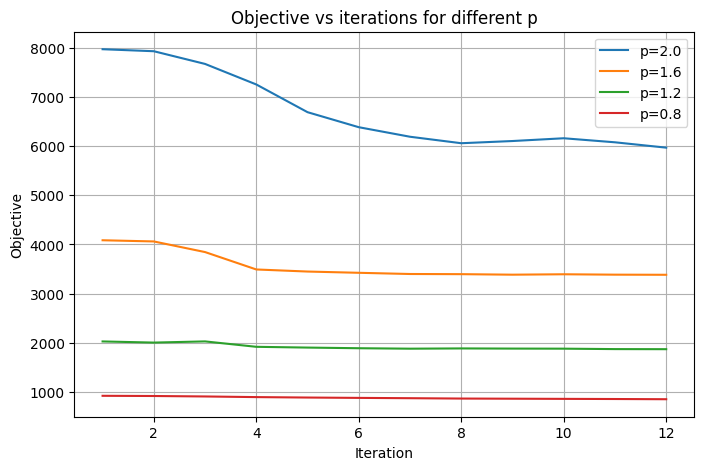

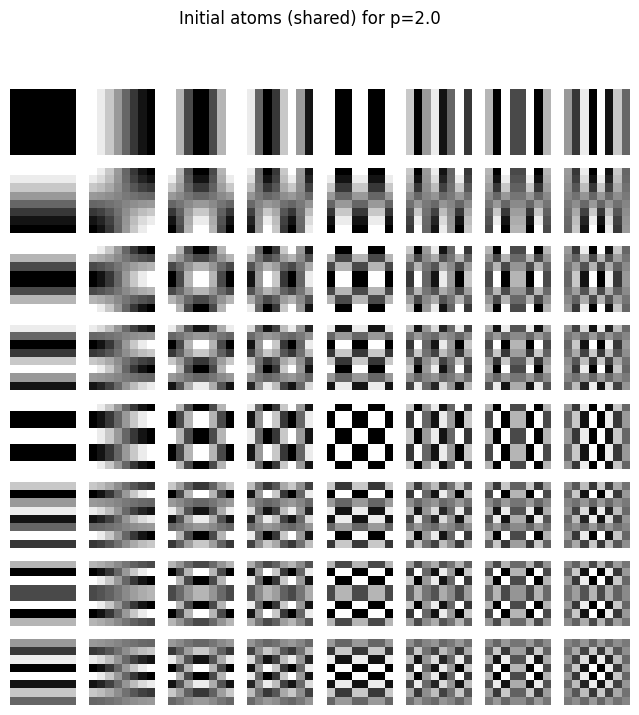

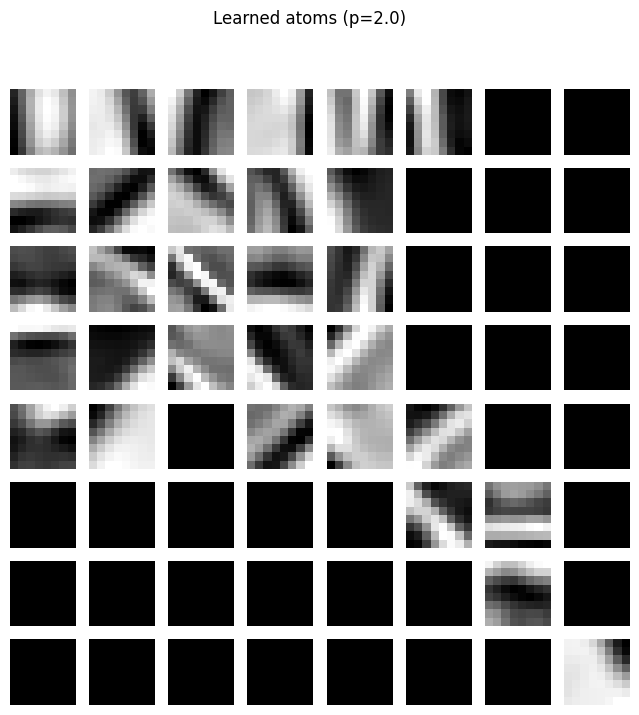

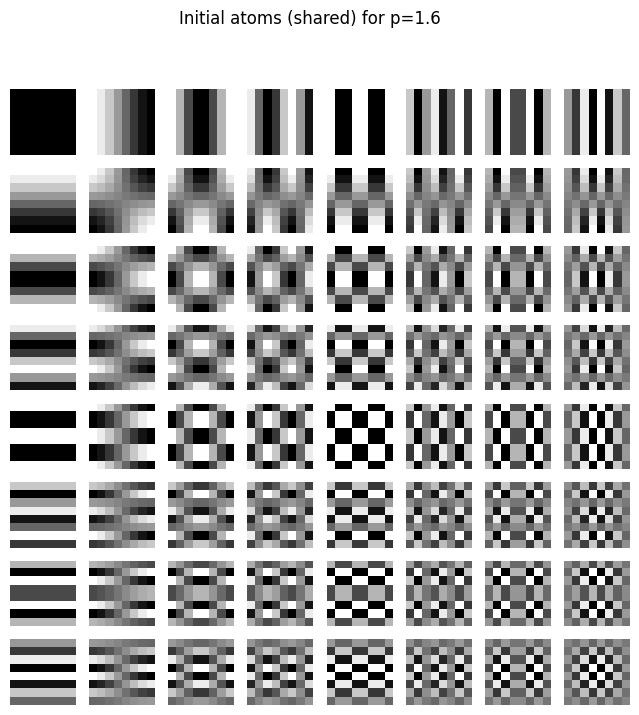

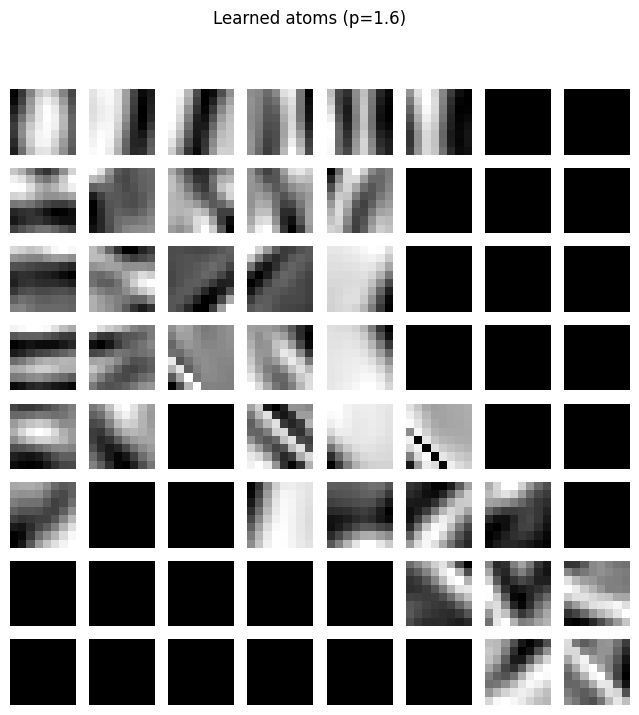

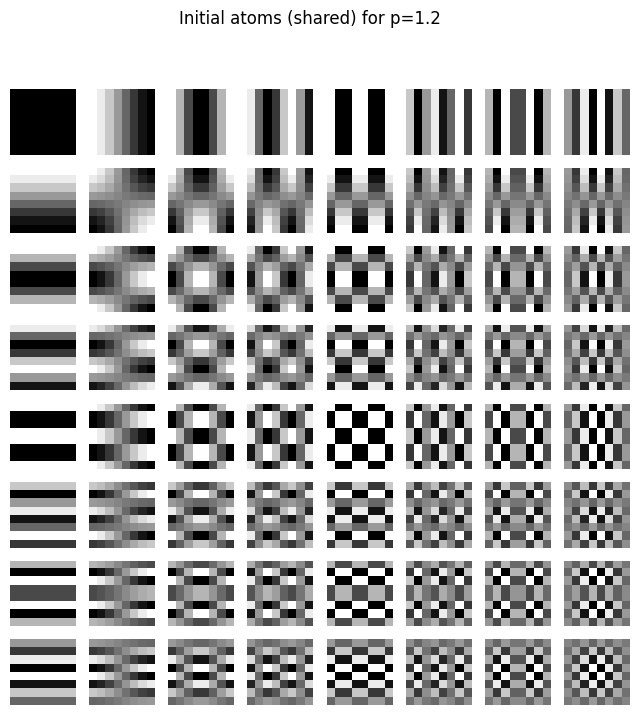

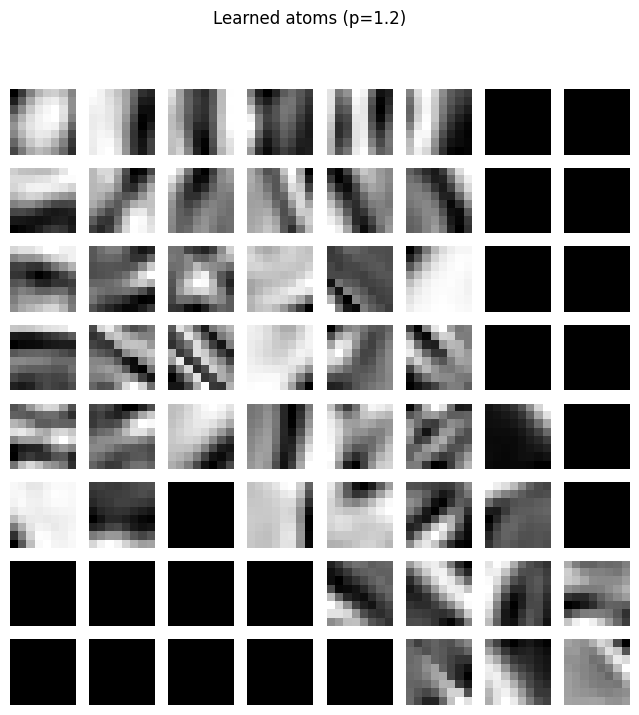

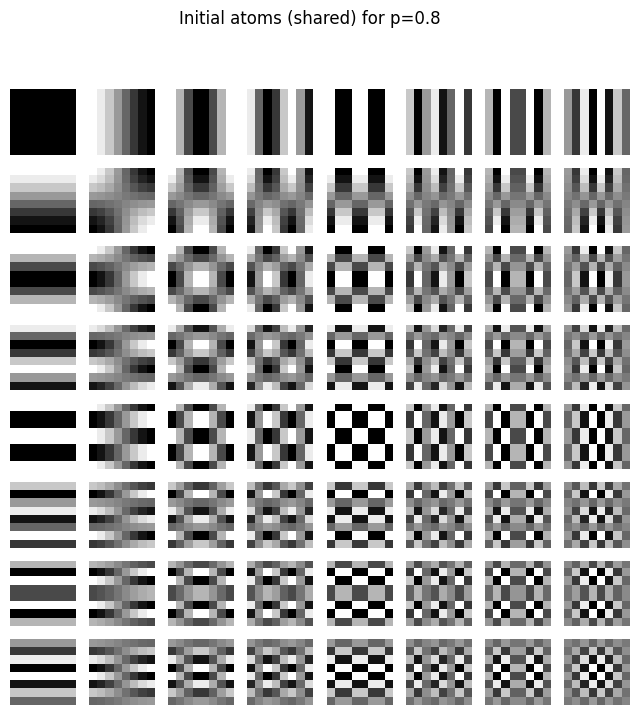

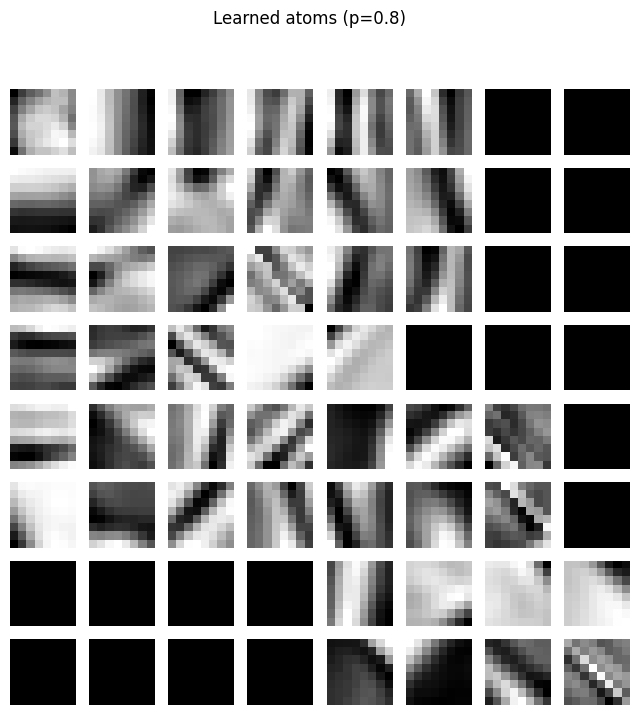

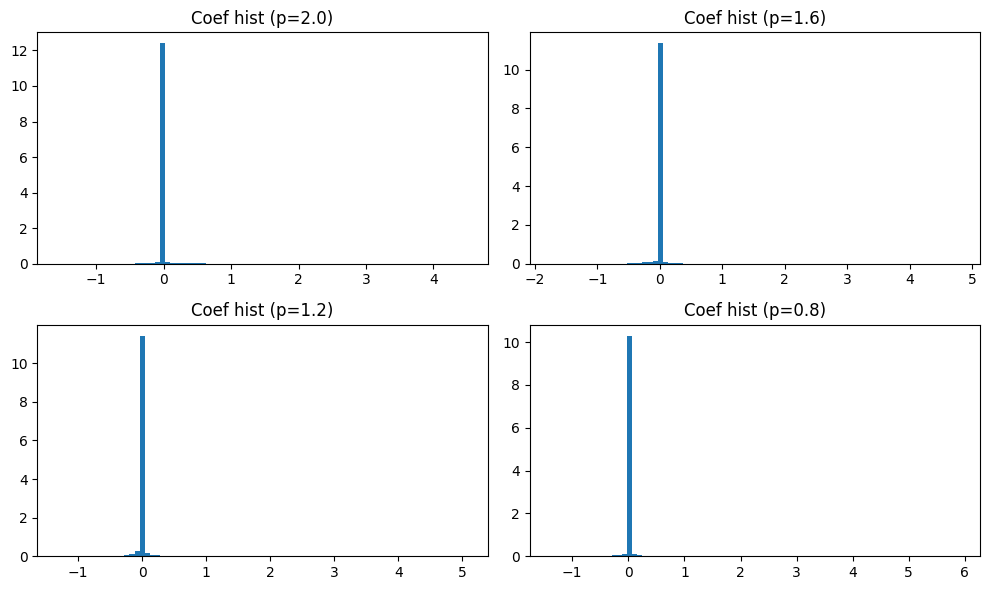

In [ ]:
p_values = [2.0, 1.6, 1.2, 0.8]
# Smaller lambda for p<1 improves convergence and sparsity balance
lam_map = {2.0:0.2, 1.6:0.15, 1.2:0.10, 0.8:0.05}
results = {}

for p in p_values:
    print("\nLearning dictionary for p =", p)
    lam = lam_map[p]
    D_learn, R_learn, objs = learn_dictionary(X, D0, p=p, lam=lam, max_iter=12, ista_iters=40, irl1_outer=4, n_subsample=min(15000, X.shape[1]), verbose=True)
    results[p] = {"D":D_learn, "R":R_learn, "objs":objs}

# Plot objective vs iterations
plt.figure(figsize=(8,5))
for p in p_values:
    o = results[p]['objs']
    plt.plot(range(1, len(o)+1), o, label=f"p={p}")
plt.xlabel("Iteration"); plt.ylabel("Objective"); plt.title("Objective vs iterations for different p")
plt.legend(); plt.grid(True); plt.show()


def show_atoms_grid(D, title="Dictionary atoms", ncols=8):
    K = D.shape[1]; pdim = D.shape[0]; ps = int(np.sqrt(pdim))
    nrows = int(np.ceil(K / ncols))
    plt.figure(figsize=(ncols, nrows))
    for k in range(K):
        plt.subplot(nrows, ncols, k+1); plt.imshow(D[:,k].reshape(ps,ps), cmap='gray'); plt.axis('off')
    plt.suptitle(title); plt.show()

for p in p_values:
    show_atoms_grid(D0, title=f"Initial atoms (shared) for p={p}")
    show_atoms_grid(results[p]['D'], title=f"Learned atoms (p={p})")

# Histograms of pooled coefficients across all r_i for each p
plt.figure(figsize=(10,6))
for i,p in enumerate(p_values,1):
    plt.subplot(2,2,i)
    R = results[p]['R']
    plt.hist(R.flatten(), bins=80, density=True)
    plt.title(f"Coef hist (p={p})")
plt.tight_layout(); plt.show()

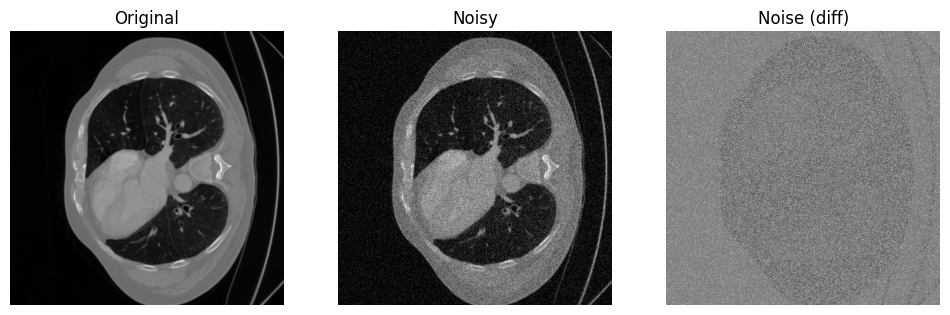

Noise std: 0.1


In [ ]:
# Simulate Noisy Image with 10% Gaussian noise

rng = np.random.default_rng(1)
intensity_range = float(chest_ct.max() - chest_ct.min())
noise_std = 0.10 * intensity_range
noisy = chest_ct + rng.normal(loc=0.0, scale=noise_std, size=chest_ct.shape)
noisy = np.clip(noisy, 0.0, 1.0)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(chest_ct, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(noisy, cmap='gray'); plt.title('Noisy'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(noisy - chest_ct, cmap='gray'); plt.title('Noise (diff)'); plt.axis('off')
plt.show()

print("Noise std:", noise_std)

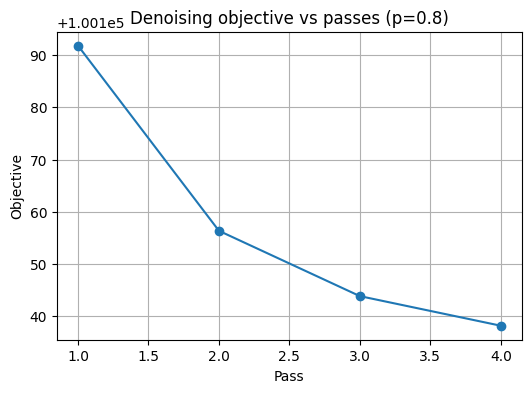

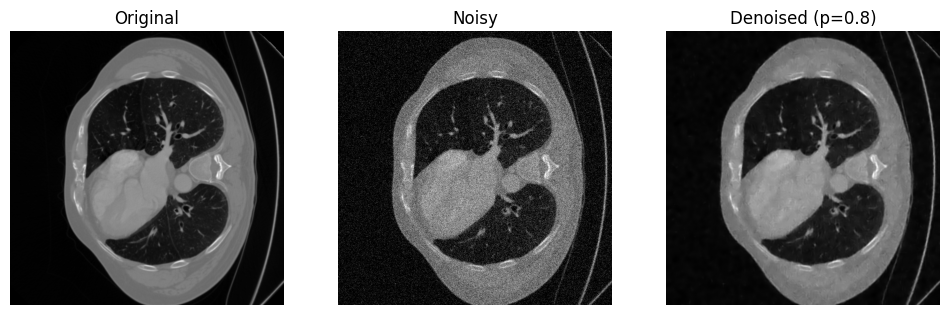

In [ ]:
# Proposed objective per patch: min_r ||y_i - D r||_2^2 + lam ||r||_p^p (p=0.8)

p_denoise = 0.8
D_p = results[p_denoise]['D']

patches_noisy, positions_noisy, hpos_n, wpos_n = extract_patches(noisy, patch_size=patch_size, stride=1)

def reconstruct_image_from_patches(patch_dim, positions_shape, patches_matrix, patch_size=8):
    h_pos, w_pos = positions_shape
    img_h = h_pos + patch_size - 1
    img_w = w_pos + patch_size - 1
    recon = np.zeros((img_h, img_w), dtype=np.float32)
    counts = np.zeros_like(recon)
    n_patches = patches_matrix.shape[1]
    idx = 0
    for i in range(h_pos):
        for j in range(w_pos):
            patch = patches_matrix[:, idx].reshape(patch_size, patch_size)
            recon[i:i+patch_size, j:j+patch_size] += patch
            counts[i:i+patch_size, j:j+patch_size] += 1
            idx += 1
    counts[counts == 0] = 1.0
    return recon / counts


lam_denoise = 0.10

obj_vals = []
R_all, w = irl1_sparse_coding_warm(D_p, patches_noisy, lam=lam_denoise, p=p_denoise, irl1_iters=6, inner_ista_iters=60, R_init=None, w_init=None)
obj_vals.append(objective(patches_noisy, D_p, R_all, lam_denoise, p_denoise))
for _ in range(3):
    R_all, w = irl1_sparse_coding_warm(D_p, patches_noisy, lam=lam_denoise, p=p_denoise, irl1_iters=3, inner_ista_iters=40, R_init=R_all, w_init=w)
    obj_vals.append(objective(patches_noisy, D_p, R_all, lam_denoise, p_denoise))

recon_patches = D_p @ R_all
denoised_img = reconstruct_image_from_patches(D_p.shape[0], (hpos_n, wpos_n), recon_patches, patch_size=patch_size)
denoised_img = np.clip(denoised_img, 0.0, 1.0)

plt.figure(figsize=(6,4))
plt.plot(range(1, len(obj_vals)+1), obj_vals, marker='o')
plt.xlabel("Pass"); plt.ylabel("Objective"); plt.title("Denoising objective vs passes (p=0.8)")
plt.grid(True); plt.show()


plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(chest_ct, cmap='gray'); plt.title('Original'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(noisy, cmap='gray'); plt.title('Noisy'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(denoised_img, cmap='gray'); plt.title('Denoised (p=0.8)'); plt.axis('off')
plt.show()
